# Gaussian process emulator example
Author: Haochen Ye (hxy46@psu.edu)

This notebook example introduces the Gaussian process and applies a Gaussian emulator to the two-dimensional reliability problem used in previous examples.

Before starting, about Gaussian process:
a Gaussian process is a collection of random variables, any finite number of which have consistent Gaussian distributions. It can be treated as a multivariate normal distribution with infinite variables (continuous case). A Gaussian process can be fully described by two key functions just like a normal distribution (mean and variance): (1) a mean function telling the mean of any input point in the input space; (2) a covariance function telling the covariance between any two points.

The code below along with figures will illustrate these concepts more directly. The entire code does not directly call any function that fits a Gaussian emulator. All the work is done based on theory and examples following this book: 

R.B. Gramacy. Surrogates: Gaussian process modeling, design and optimization for the applied
sciences (2020). Chapman Hall/CRC, Boca Raton, FL. (https://bookdown.org/rbg/surrogates/)

In [8]:
# remove all existing variables and plots
rm(list = ls())
graphics.off()
# load the required libraries
library(mvtnorm)  # Multivariate normal distribution library
library(lhs) #Generate Latin Hypercube samples
library(fields) # Make grid plots
options(warn=-1) # Suppress warnings 

# 1-D example of Gaussian process
We begin with an example of 1-D Gaussian process realization defined by its mean function and covariance function. The covariance function is a matrix that describes the dependence between any two points. There exists multiple options to define the covariance matrix. The key idea behind it is that: for any two points, the larger their distance is, the less dependent they are. A common choice is a covariance exponentially decayed with respect to distance.

In this example, we assume an exponentially decayed covariance matrix, and the variances (diagnal elements) are 1. We add a small number near to zero to the matrix in case the matrix inversion used in later analysis has a illed- condition in some cases, though theoretically this is unnecessary (Neal, 1998).

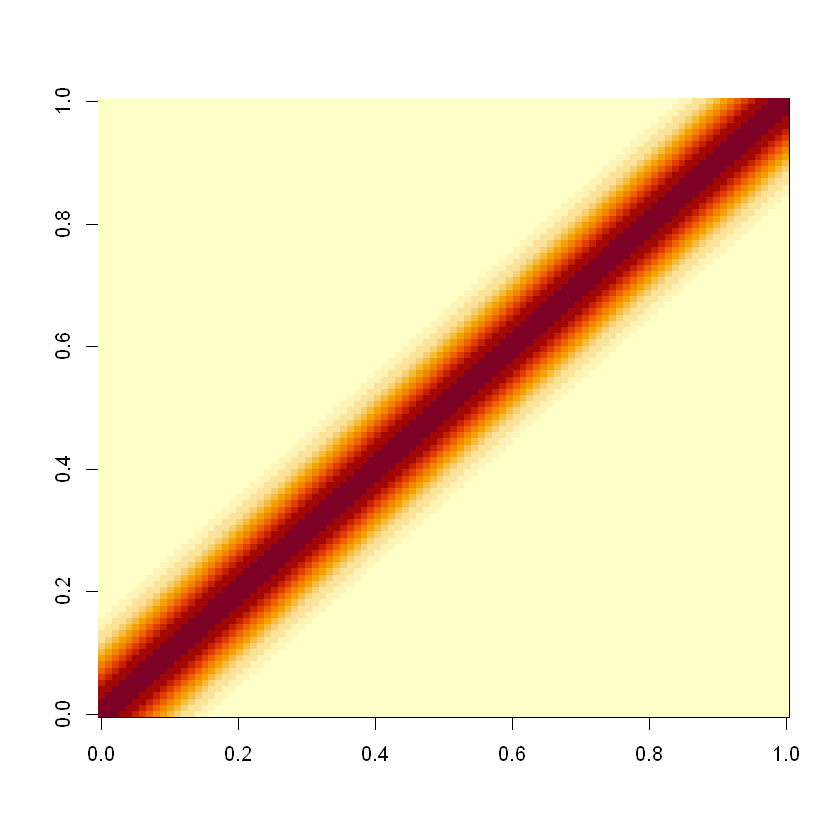

In [9]:
# input samples
n <- 100 
X <- matrix(seq(0, 10, length=n), ncol=1)
# Distance between each input pair, used to define covariance matrix
D <- distance(X)
# Adding a very small number to aviod ill-conditioned matrix calculation that may happen 
#   for square matrix sometimes. (Neal, 1998)
eps <- sqrt(.Machine$double.eps)
# Assume the covariance decays exponentially with respect to distance
Sigma <- exp(-D) + diag(eps, n)
image(Sigma)

This figure shows the covariance between any two points. Red grids represent higher covariance. The variance of any element is always 1 by our definition above. We see that if two points are close to each other, they will have a higher correlation, otherwise they are almost independent.

Now we define the covariance function, we still need a mean function to define a Gaussian process. We simply define the mean values as 1 everywhere.

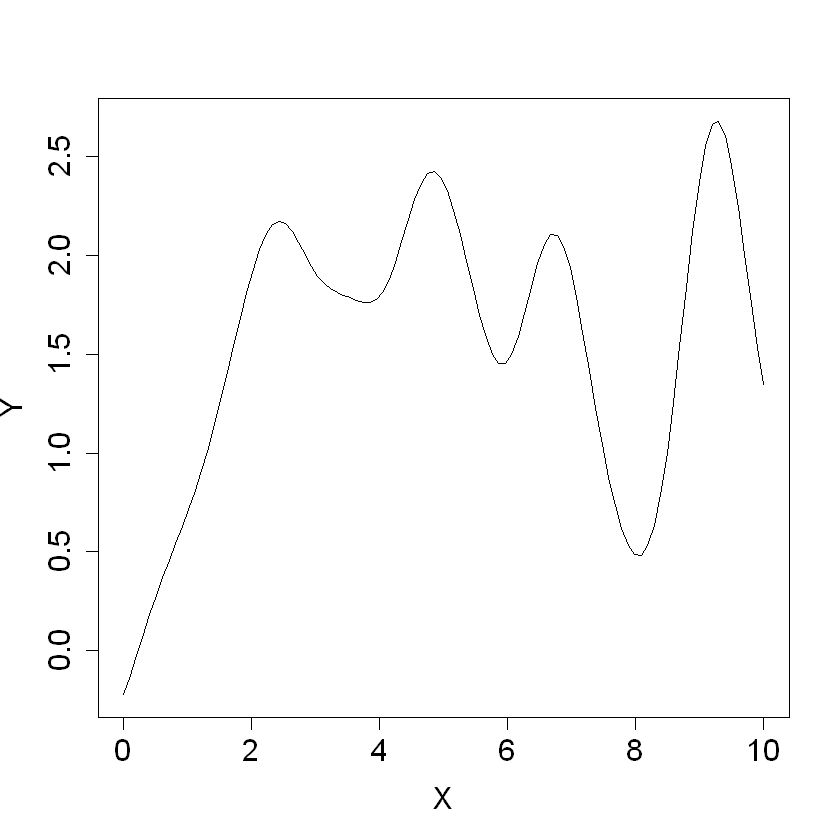

In [10]:
# Generate random output values by mean and sigma (assume mean is 1 everywhere) 
Y <- mvtnorm::rmvnorm(1, rep(1,100), sigma=Sigma)
plot(X, Y, type="l",cex.axis=1.5,cex.lab=1.5)

This is an example of a smooth function under Gaussian process. We can generate more functions under the same mean and covariance, and we can see that they are very different.

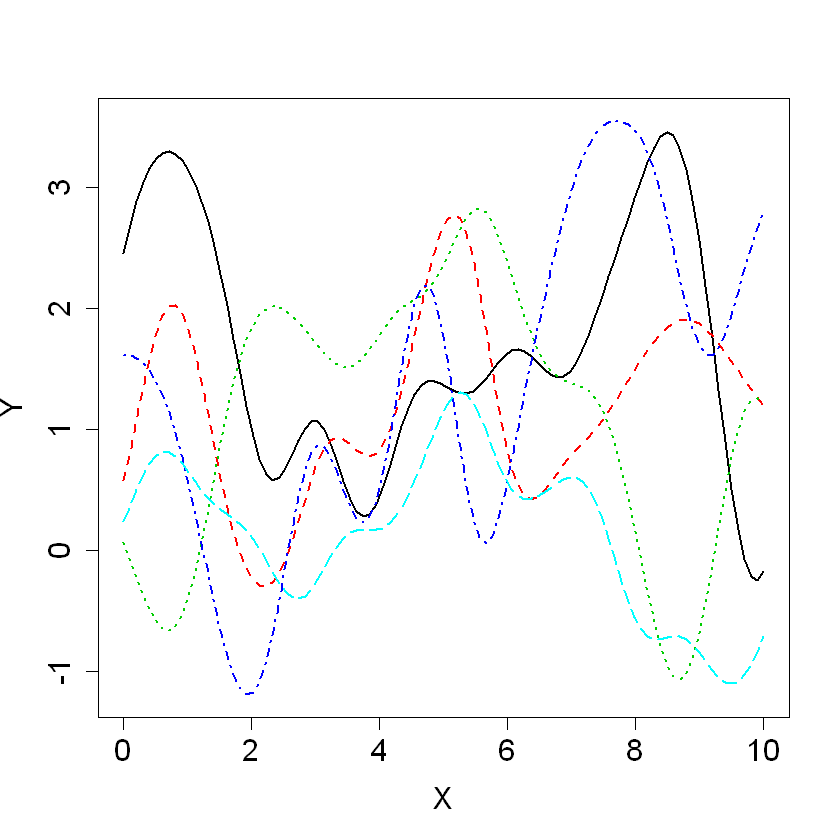

In [11]:
Y <- mvtnorm::rmvnorm(n=5,rep(1,100), sigma=Sigma)
matplot(X, t(Y),lwd=2, type="l", ylab="Y",cex.axis=1.5,cex.lab=1.5)

# 1-D Gaussian process regression (Kriging) 
Next we focus on the problem of fitting and predicting. Assume we have some observed sample points, and we want to estimate the output values of all unobserved points. Gaussian process regression can deal with this problem, and this process is called Kriging in geostatistics. We use a simple one-dimensional example to show this process.

Assume we have eight samples with equal spaces, and we have eight corresponding output values. The first step of Gaussian process regression is to calculate the covariance matrix of these samples.

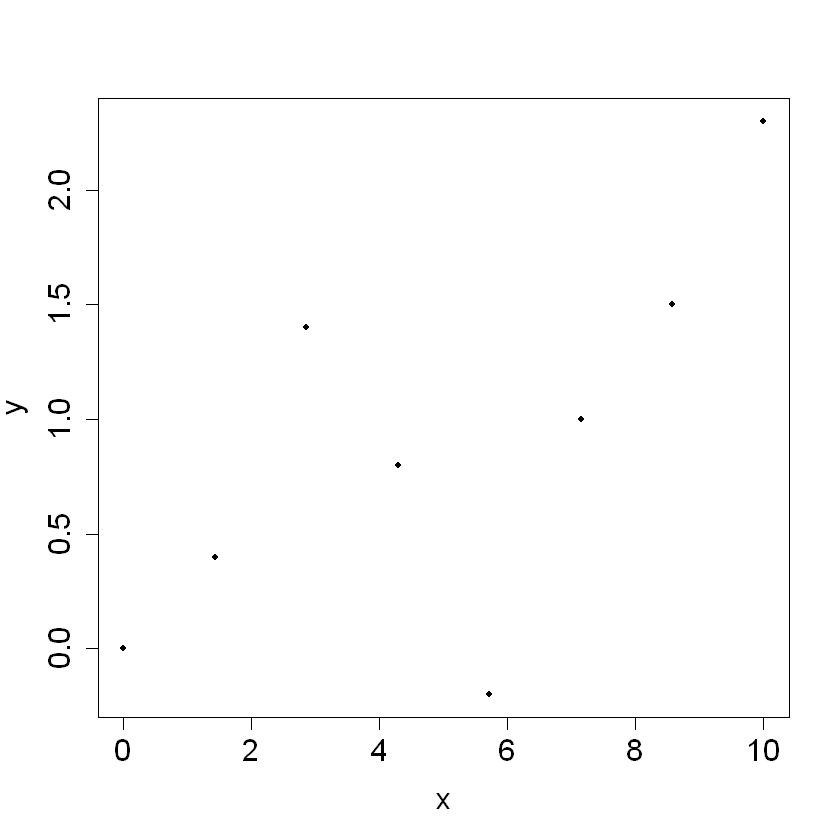

In [12]:
# 8 samples with equal space between every neighbour 
n <- 8
x <- matrix(seq(0, 10, length=n), ncol=1)
# Assigned sample outputs
y <- c(0,0.4,1.4,0.8,-0.2,1,1.5,2.3)
plot(x,y,pch=20,cex.axis=1.5,cex.lab=1.5)
# Sample distances and covariance
d <- distance(x) 
Sigma <- exp(-d) + diag(eps, ncol(d))

This figure visualizes the eight known samples. Remember the task is to estimate y(x) in the entire input space. Intuitively we will think that points near a known sample will have a similar output value to this sample. This is exactly the interpretation of the covariance function. 

The next step is to select many unobserved points (100 points in this example). The entire regression process is actually a linear predictor. To estimate the global mean and covariance function, we further need (1) the covariance of unobserved data; (2) the covariance between known samples and unobserved data. 

In [13]:
# Unobserved data points
X <- matrix(seq(0, 10, length=100), ncol=1)
# Denote the covariance of unobserved data as SX
DX <- distance(X)
SX <- exp(-DX) + diag(eps, ncol(DX))
# The covariance between samples and unobserved data is S
D <- distance(X, x)
S <- exp(-D)

The best estimator of mean function is: S Sigma^-1 y (Sigma is sample covariance, y is sample output)
The best estimator of covariance function is: SX - S Sigma^-1 S^T

We do not further discuss the exact deduction process of these results in this notebook. 

*The reason to add a small number in the covariance matrix is to avoid near-singular matrix in the matrix inversion step here.

In [14]:
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)

Now we can generate the output of a fitted function by the mean function and covariance function:

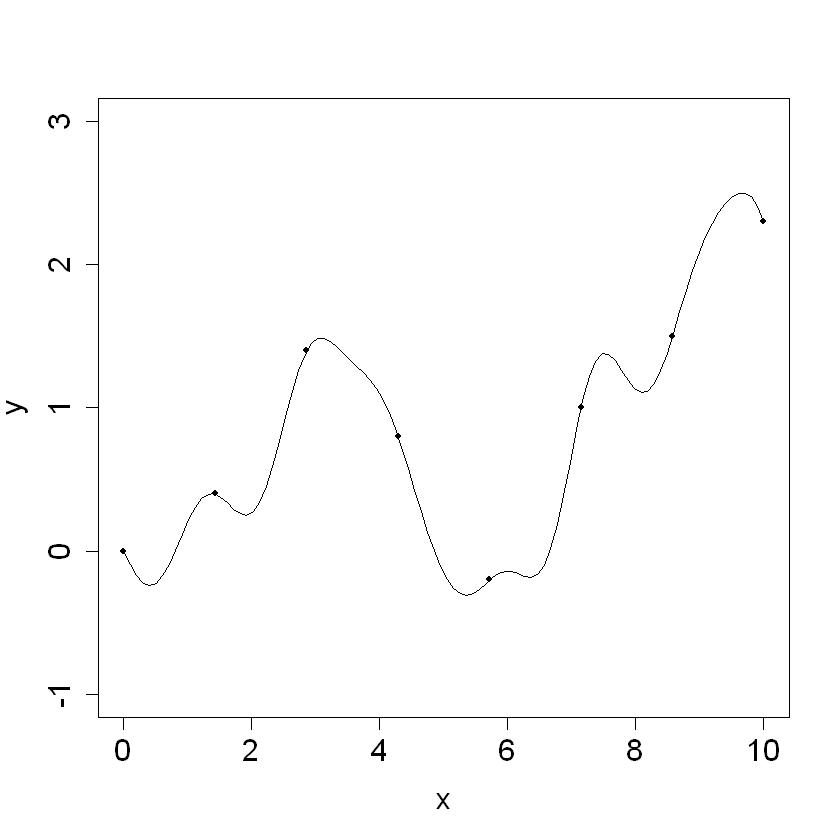

In [15]:
Y <- mvtnorm::rmvnorm(1, mup, Sigmap)
plot(x,y,pch=20,ylim=c(-1,3),cex.axis=1.5,cex.lab=1.5)
lines(X,Y)

As expected, we see a smooth function connecting the eight sample points. However, this is just a single example of possible response curve. Then we add the model best fit as well as the 95% uncertainty range.

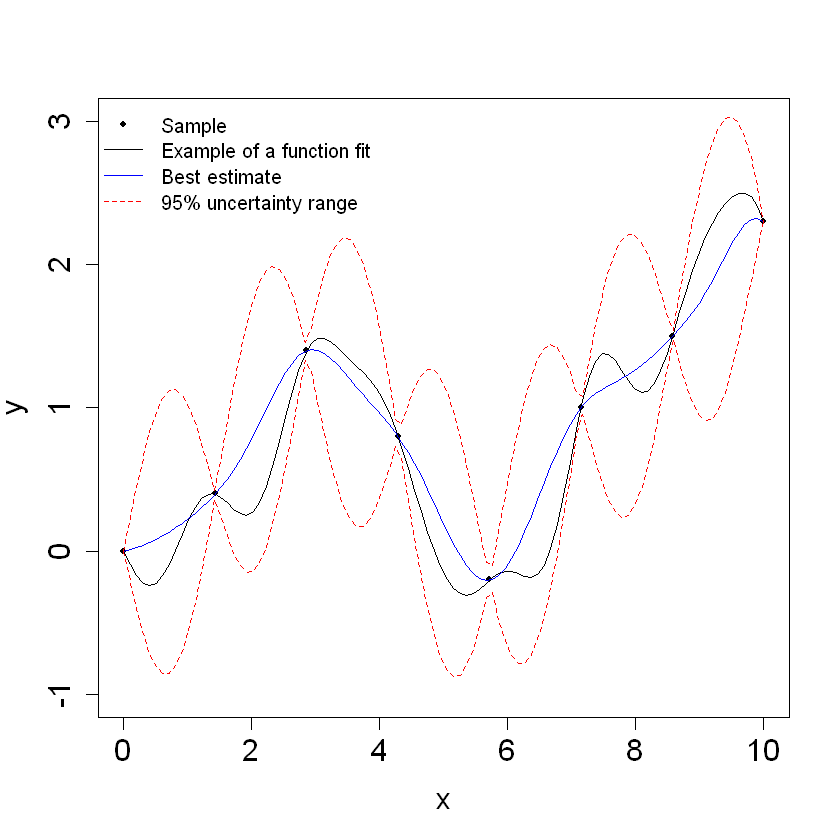

In [18]:
plot(x,y,pch=20,ylim=c(-1,3),cex.axis=1.5,cex.lab=1.5)
lines(X,Y)
lines(X,mup,col="blue")
up <- mup + qnorm(0.05, 0, sqrt(diag(Sigmap)))
low <- mup + qnorm(0.95, 0, sqrt(diag(Sigmap)))
lines(X,up,col="red",lty=2)
lines(X,low,col="red",lty=2)
legend("topleft",col=c("black","black","blue","red"),lty=c(NA,1,1,2),pch=c(20,NA,NA,NA),bty="n",
       legend=c("Sample","Example of a function fit","Best estimate","95% uncertainty range"))

Now we get an example of one-dimensional Gaussian process emulator. If the model is computationally expensive and we only can get these eight samples, we can have a rough idea of what the responses are for other unobserved point. The blue line is our best guess. 

Note that we are actually only estimating the outputs of the 100 selected points and connecting them by a curve. An ideal Gaussian process emulator expands into infinite points and generate a continuous response in the entire space. This is an approximation, though good enough in this simple case. For more complex problems, 100 points is far from enough. Similarly, only eight known samples is far from enough for multi-dimensional or complex models.

# 2-D Gaussian process emulator for a reliability problem
We then expand the analysis to our reliability problem used in previous sensitivity analysis. The process is similar to 1D case. 

We begin with the problem definition.

In [19]:
Reliability<-function (X) {
  floor(X[ ,1]*X[ ,2]/0.75)
}

First sample 2-d inputs, calculate corresponding output, distance, covariance. Here we take 100 samples by Latin Hypercube sampling.

In [20]:
n <- 100
x <- data.frame(randomLHS(n,2))
y <- Reliability(x)
d <- distance(x)
Sigma <- exp(-d) + diag(eps, nrow(x))

Then select some evenly distributed unobserved data points and calculate covariance. Here we take 50*50 = 2500 points.

In [21]:
level <- seq(0, 1, length=50)
X <- expand.grid(level,level)
DX <- distance(X)
SX <- exp(-DX) + diag(eps, ncol(DX))
D <- distance(X, x)
S <- exp(-D)

Finally we insert these results into the linear estimator.

In [22]:
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)

We visulize the mean response of these unobserved points. In 2D case, it is not convenient to show the mean response and uncertainty in one figure clearly. Here we first plot the mean.

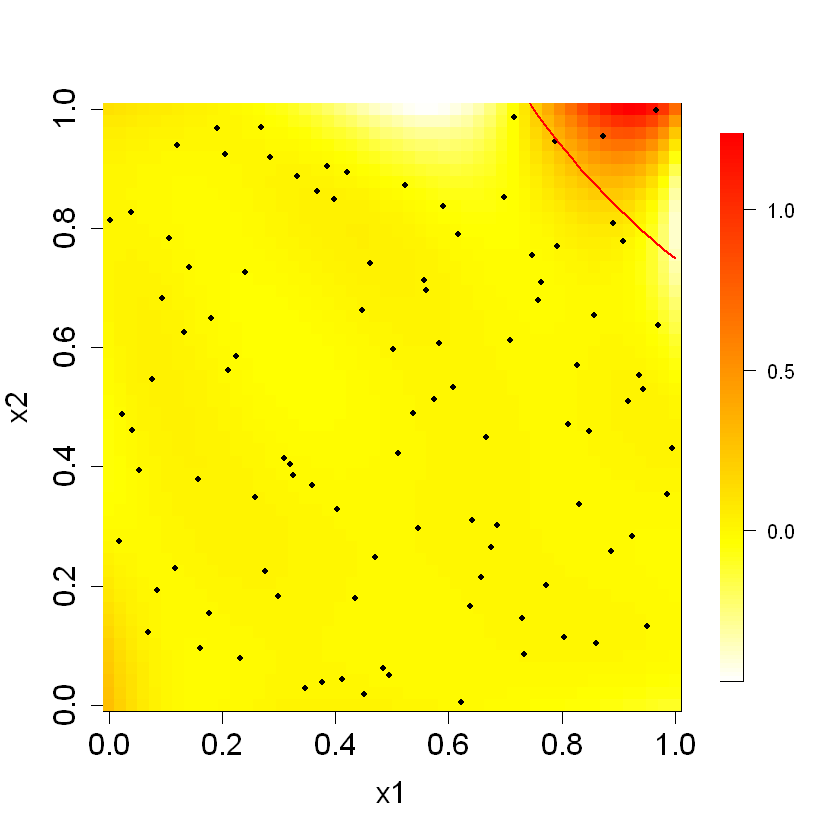

In [28]:
cols <- rev(heat.colors(128))
image.plot(level,level, matrix(mup,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1,x$X2,pch=20)
lines(level,0.75/level,col="red",lwd=2)

Recall that the true response is 1 on the upper-right corner beyond the red line, and 0 everywhere else. We see a similar pattern in the mean Gaussian process emulator with only 100 input samples, and only two falls in the failing area. We repeat the analyze with 500 input samples.

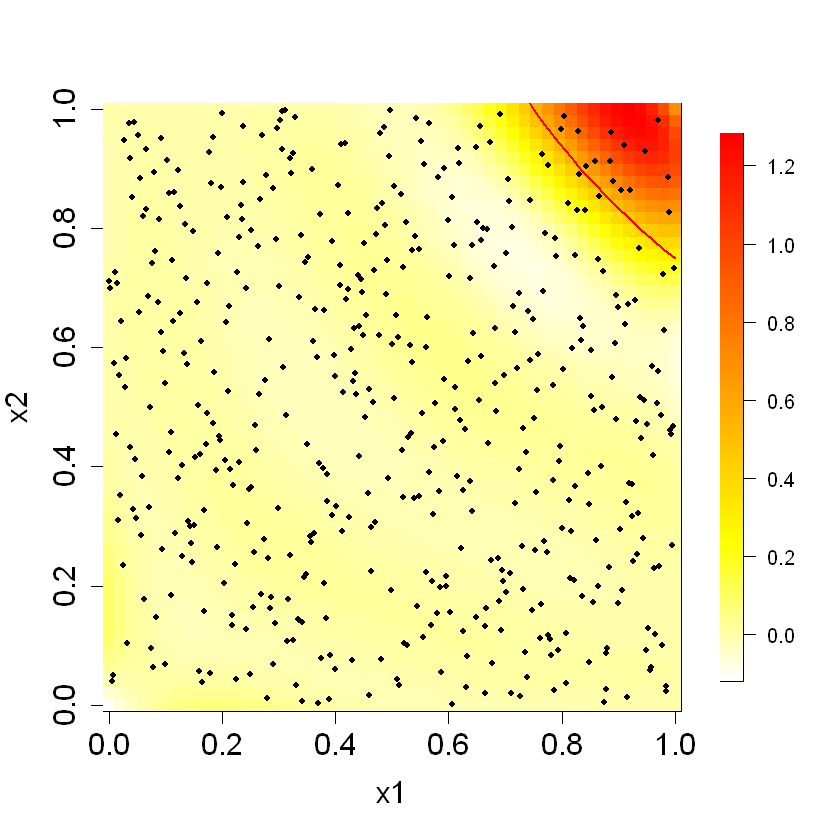

In [29]:
n <- 500
x <- data.frame(randomLHS(n,2))
y <- Reliability(x)
d <- distance(x)
Sigma <- exp(-d) + diag(eps, nrow(x))
SX <- exp(-DX) + diag(eps, ncol(DX))
D <- distance(X, x)
S <- exp(-D)
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)
image.plot(level,level, matrix(mup,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1,x$X2,pch=20)
lines(level,0.75/level,col="red",lwd=2)

This time the mean response is very close to the true response.

Then we plot the uncertainty range. We use the standard deviation of each point to represent the uncertainty. Note that we added a small number to the covariance matrix, this may lead to some slightly negative variances for some points. Usually this happens when our sample size is big enough to reduce the uncertainty bound to almost zero. We can just treat the uncertainties as zero for these points. In order to avoid this problem, we use the standard deviation results when there are only 25 samples. This sample size is small so that most variances are significantly larger than 0.

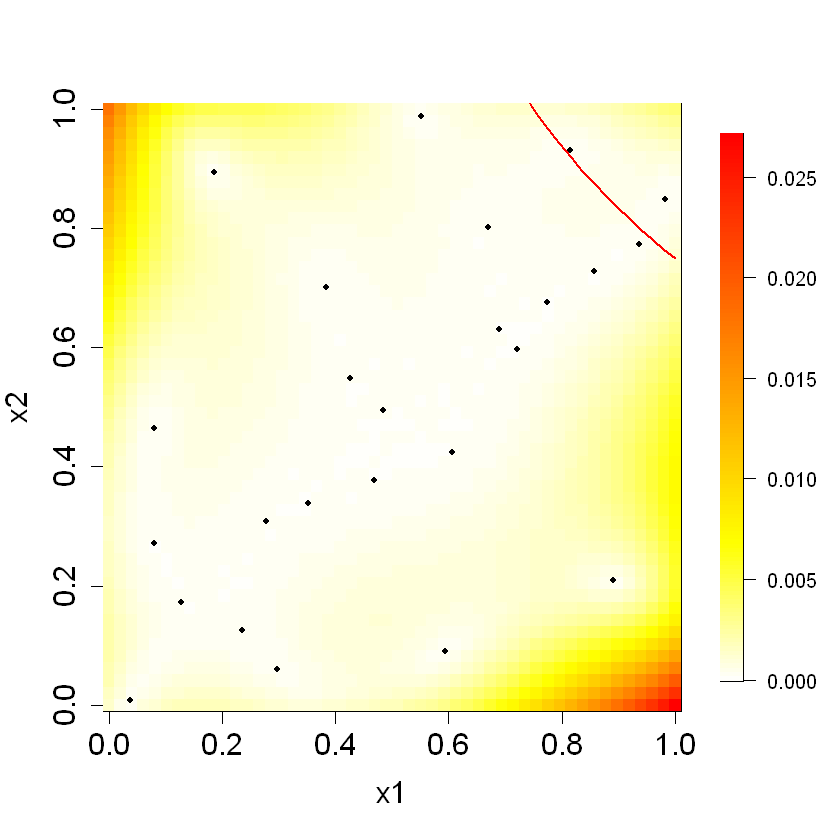

In [33]:
n <- 25
x <- data.frame(randomLHS(n,2))
y <- Reliability(x)
d <- distance(x)
Sigma <- exp(-d) + diag(eps, nrow(x))
SX <- exp(-DX) + diag(eps, ncol(DX))
D <- distance(X, x)
S <- exp(-D)
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)
image.plot(level,level, matrix(sqrt(diag(Sigmap)),ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1,x$X2,pch=20)
lines(level,0.75/level,col="red",lwd=2)

Even with on 25 samples, the uncertainties near these samples are almost 0 (largely due to the simplicity of our model definition). For corners with low sample density, the uncertainties are larger.

However, we should notice that if we only take 25 samples, it is likely that no sample falls to the failure region. The consequence is that all sampled outputs are zero, and the Gaussian process emulator will fail. This is why we start with 100 samples. For this type of reliability problem with a very low failing probability, we need to at least take some samples in the failure region to get an acceptable emulator. 